# Model

## Libraries

In [1]:
# Libraries
# Data handling
import pandas as pd
import numpy as np
import warnings

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import statsmodels.api as sm
import statsmodels.stats.api as sms
from linearmodels.panel import PanelOLS
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr
from statsmodels.stats.descriptivestats import describe 
import pylab 
import scipy.stats as stats
import math

# Further set up
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppressing warnings
myst_dmath_allow_labels=True

## Data

In [2]:
# Returns
RET_Daily = pd.read_excel('Data.xlsx','Excess_Returns', index_col=0)
Spot_prices = pd.read_excel('Data.xlsx','Spot_Sorted', index_col=0)

# GPR
GPR_Monthly = pd.read_excel('Data.xlsx','GPR_Monthly', index_col=0)
GPR_Daily = pd.read_excel('Data.xlsx','GPR_Daily', index_col=0)

GPR_Monthly_LOG = pd.read_excel('Data.xlsx','GPR_Monthly_LOG', index_col=0)
GPR_Daily_LOG = pd.read_excel('Data.xlsx','GPR_Daily_LOG', index_col=0)

GPR_Monthly_Diff = pd.read_excel('Data.xlsx','GPR_Monthly_Diff', index_col=0)
GPR_Daily_Diff = pd.read_excel('Data.xlsx','GPR_Daily_Diff', index_col=0)

# Country / Market Classification
Markets = pd.read_excel('Data.xlsx','Markets')
Regions = pd.read_excel('Data.xlsx','Regions')

# Interest Rates
IR = pd.read_excel('Data.xlsx','Interest_Rates', index_col=0) 

## Portfolio Set-up

In [4]:
# Regressing currency returns on GPR to extract currency coefficients for each period
merged = pd.merge(RET_Daily,GPR_Daily['GPRD'], how='inner',left_index=True, right_index=True)
returns = merged.iloc[:, 0:18]
returns['const'] = 1
GPR = merged.iloc[:, -1:]

betas = pd.DataFrame(index=returns.index, columns = returns.columns.tolist())

for x in returns.index:
    X = returns.loc[x, :].values.reshape(1, -1) 
    Y = GPR.loc[x].values 

    #X = sm.add_constant(X)  

    model = sm.OLS(Y, X)
    results = model.fit()
    
    betas.loc[x] = results.params

with pd.ExcelWriter('Betas.xlsx', engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer: # Exporting to Excel
    betas.to_excel(writer, sheet_name="Betas")

In [17]:
# HML based sensitivity to GPR
HML_RET_temp = pd.read_excel('Betas.xlsx','HML', index_col=0) # Importing from Excel
HML_RET_temp = HML_RET_temp.resample('M').sum()
HML_RET = HML_RET_temp
HML_RET

HML
Date                
1997-01-31  0.049242
1997-02-28  0.005922
1997-03-31 -0.014700
1997-04-30 -0.025503
1997-05-31 -0.035710
...              ...
2024-01-31  0.271007
2024-02-29  0.252368
2024-03-31  0.237225
2024-04-30  0.243821
2024-05-31  0.226393

[329 rows x 1 columns]

## Volatility clalculations

In [18]:
REL_VOL_temp = pd.read_excel('Data.xlsx','VOL', index_col=0) # Importing from Excel
REL_VOL = REL_VOL_temp.mean(axis=1)
VOL = REL_VOL
VOL

Date
1997-01-31    0.018337
1997-02-28    0.014834
1997-03-31    0.019088
1997-04-30    0.017120
1997-05-30    0.016728
                ...   
2024-01-31    0.025613
2024-02-29    0.021122
2024-03-29    0.020355
2024-04-30    0.015838
2024-05-31    0.018160
Length: 329, dtype: float64

### Summary Statistics: Monthly Data

In [19]:
# Summary statistics for HML returns
table1 = round(describe(HML_RET),3)
table1

HML
nobs              329.000
missing             0.000
mean                0.332
std_err             0.007
upper_ci            0.345
lower_ci            0.319
std                 0.122
iqr                 0.099
iqr_normal          0.074
mad                 0.079
mad_normal          0.099
coef_var            0.367
range               0.972
max                 0.937
min                -0.036
skew                0.504
kurtosis            8.084
jarque_bera       368.234
jarque_bera_pval    0.000
mode               -0.036
mode_freq           0.003
median              0.327
1%                 -0.014
5%                  0.196
10%                 0.240
25%                 0.278
50%                 0.327
75%                 0.377
90%                 0.442
95%                 0.526
99%                 0.718

In [20]:
# Summary statistics for monthly first difference GPR returns
table2 =round(describe(GPR_Monthly_Diff['GPR']),3)
table2

GPR
nobs                329.000
missing               0.000
mean                  0.147
std_err               1.985
upper_ci              4.038
lower_ci             -3.743
std                  36.004
iqr                  21.681
iqr_normal           16.072
mad                  17.725
mad_normal           22.215
coef_var            244.195
range               640.284
max                 434.540
min                -205.744
skew                  4.811
kurtosis             70.132
jarque_bera       63049.058
jarque_bera_pval      0.000
mode               -205.744
mode_freq             0.003
median               -0.832
1%                  -87.222
5%                  -32.964
10%                 -24.124
25%                 -11.973
50%                  -0.832
75%                   9.709
90%                  22.950
95%                  34.069
99%                  95.109

In [21]:
# Summary statistics for volatility
table3 = round(describe(REL_VOL),3)
table3

0
nobs              329.000
missing             0.000
mean                0.026
std_err             0.000
upper_ci            0.027
lower_ci            0.025
std                 0.009
iqr                 0.008
iqr_normal          0.006
mad                 0.006
mad_normal          0.007
coef_var            0.332
range               0.058
max                 0.072
min                 0.014
skew                2.167
kurtosis            9.524
jarque_bera       840.820
jarque_bera_pval    0.000
mode                0.014
mode_freq           0.003
median              0.024
1%                  0.014
5%                  0.017
10%                 0.018
25%                 0.020
50%                 0.024
75%                 0.028
90%                 0.035
95%                 0.043
99%                 0.059

In [22]:
# Summary statistics for monthly excess returns
table4 = round(describe(RET_Daily.resample('M').mean()),3)
table4 

USD/AUD  USD/CAD  USD/CHF  USD/DKK  USD/EUR  USD/GBP  \
nobs               329.000  329.000  329.000  329.000  329.000  329.000   
missing              0.000    0.000    0.000    0.000    0.000    0.000   
mean                -0.000   -0.000   -0.000   -0.000    0.000   -0.000   
std_err              0.000    0.000    0.000    0.000    0.000    0.000   
upper_ci             0.000    0.000    0.000    0.000    0.000    0.000   
lower_ci            -0.000   -0.000   -0.000   -0.000   -0.000   -0.000   
std                  0.002    0.001    0.002    0.002    0.002    0.002   
iqr                  0.002    0.002    0.002    0.002    0.003    0.002   
iqr_normal           0.002    0.001    0.002    0.002    0.002    0.002   
mad                  0.002    0.001    0.001    0.001    0.002    0.001   
mad_normal           0.002    0.001    0.002    0.002    0.002    0.002   
coef_var         -1892.350 -283.645 -249.221 -431.946   70.574 -267.110   
range                0.014    0.011    0.016    0.016    0.016    0.010   
max                  0.006    0.007    0.008    0.009    0.007    0.005   
min                 -0.008   -0.004   -0.008   -0.007   -0.009   -0.005   
skew                -0.178    0.282    0.039    0.355    0.105   -0.005   
kurtosis             3.761    4.561    5.176    5.470    4.159    3.223   
jarque_bera          9.666   37.774   64.982   90.577   19.020    0.686   
jarque_bera_pval     0.008    0.000    0.000    0.000    0.000    0.710   
mode                -0.008   -0.004   -0.008   -0.007   -0.009   -0.005   
mode_freq            0.003    0.003    0.003    0.003    0.003    0.003   
median              -0.000   -0.000    0.000    0.000   -0.000   -0.000   
1%                  -0.005   -0.004   -0.005   -0.004   -0.005   -0.004   
5%                  -0.003   -0.002   -0.003   -0.003   -0.003   -0.002   
10%                 -0.003   -0.002   -0.002   -0.002   -0.002   -0.002   
25%                 -0.001   -0.001   -0.001   -0.001   -0.001   -0.001   
50%                 -0.000   -0.000    0.000    0.000   -0.000   -0.000   
75%                  0.001    0.001    0.001    0.001    0.001    0.001   
90%                  0.003    0.002    0.002    0.002    0.003    0.002   
95%                  0.004    0.002    0.003    0.003    0.004    0.003   
99%                  0.005    0.004    0.005    0.004    0.005    0.004   

                   USD/IDR  USD/JPY  USD/MXN    USD/MYR  USD/NOK  USD/PHP  \
nobs               329.000  329.000  329.000    329.000  329.000  329.000   
missing              0.000    0.000    0.000      0.000    0.000    0.000   
mean                 0.000    0.000   -0.000     -0.000   -0.000    0.000   
std_err              0.000    0.000    0.000      0.000    0.000    0.000   
upper_ci             0.000    0.000    0.000      0.000    0.000    0.000   
lower_ci            -0.000   -0.000   -0.000     -0.000   -0.000   -0.000   
std                  0.004    0.002    0.002      0.002    0.002    0.001   
iqr                  0.002    0.002    0.002      0.001    0.003    0.001   
iqr_normal           0.001    0.002    0.002      0.001    0.002    0.001   
mad                  0.002    0.001    0.001      0.001    0.002    0.001   
mad_normal           0.002    0.002    0.002      0.001    0.002    0.001   
coef_var           811.972  171.441 -174.283  -9056.780 -398.554  356.277   
range                0.054    0.014    0.010      0.022    0.014    0.013   
max                  0.028    0.009    0.005      0.006    0.006    0.006   
min                 -0.026   -0.005   -0.005     -0.016   -0.007   -0.007   
skew                -0.077    0.427   -0.032     -3.115   -0.018    0.085   
kurtosis            24.059    4.547    3.126     32.165    3.338    7.421   
jarque_bera       6079.948   42.844    0.275  12192.722    1.583  268.338   
jarque_bera_pval     0.000    0.000    0.871      0.000    0.453    0.000   
mode                -0.026   -0.005   -0.005     -0.016   -0.007   -0.007   
m

In [23]:
# Summary statistics for monthly spot prices
table5 = round(describe(Spot_prices.resample('M').mean()),3)
table5

USD/AUD  USD/CAD  USD/CHF  USD/DKK  USD/EUR  USD/GBP  \
nobs              329.000  329.000  329.000  329.000  329.000  329.000   
missing             0.000    0.000    0.000    0.000    0.000    0.000   
mean                1.367    1.269    1.150    6.404    0.860    0.659   
std_err             0.013    0.010    0.014    0.047    0.006    0.005   
upper_ci            1.393    1.287    1.178    6.495    0.872    0.669   
lower_ci            1.340    1.250    1.123    6.313    0.847    0.650   
std                 0.244    0.173    0.255    0.846    0.114    0.090   
iqr                 0.279    0.254    0.364    1.118    0.149    0.123   
iqr_normal          0.207    0.188    0.270    0.829    0.111    0.091   
mad                 0.186    0.143    0.219    0.667    0.089    0.074   
mad_normal          0.233    0.179    0.274    0.835    0.112    0.093   
coef_var            0.178    0.136    0.221    0.132    0.132    0.137   
range               1.083    0.646    1.000    4.018    0.540    0.412   
max                 2.015    1.600    1.784    8.764    1.177    0.896   
min                 0.932    0.954    0.784    4.746    0.636    0.484   
skew                0.414   -0.075    0.841    0.596    0.595    0.230   
kurtosis            3.012    2.054    2.481    3.217    3.215    2.278   
jarque_bera         9.420   12.581   42.517   20.111   20.050   10.063   
jarque_bera_pval    0.009    0.002    0.000    0.000    0.000    0.007   
mode                0.932    0.954    0.784    4.746    0.636    0.484   
mode_freq           0.003    0.003    0.003    0.003    0.003    0.003   
median              1.348    1.296    1.016    6.367    0.856    0.641   
1%                  0.941    0.970    0.852    4.801    0.644    0.494   
5%                  0.969    0.995    0.892    5.187    0.696    0.510   
10%                 1.042    1.015    0.908    5.409    0.725    0.544   
25%                 1.228    1.114    0.946    5.743    0.771    0.606   
50%                 1.348    1.296    1.016    6.367    0.856    0.641   
75%                 1.507    1.368    1.310    6.862    0.920    0.729   
90%                 1.698    1.509    1.524    7.521    1.011    0.791   
95%                 1.853    1.543    1.664    8.182    1.099    0.810   
99%                 1.951    1.588    1.748    8.592    1.152    0.831   

                    USD/IDR  USD/JPY  USD/MXN  USD/MYR  USD/NOK  USD/PHP  \
nobs                329.000  329.000  329.000  329.000  329.000  329.000   
missing               0.000    0.000    0.000    0.000    0.000    0.000   
mean              10807.955  111.017   13.752    3.777    7.517   47.612   
std_err             162.878    0.842    0.227    0.029    0.079    0.347   
upper_ci          11127.190  112.668   14.197    3.834    7.672   48.292   
lower_ci          10488.720  109.366   13.306    3.721    7.362   46.932   
std                2954.339   15.278    4.124    0.522    1.434    6.296   
iqr                4515.245   15.380    7.447    0.739    2.368    8.462   
iqr_normal         3347.156   11.401    5.520    0.548    1.755    6.273   
mad                2480.090   11.288    3.574    0.397    1.221    4.973   
mad_normal         3108.332   14.147    4.480    0.498    1.530    6.232   
coef_var              0.273    0.138    0.300    0.138    0.191    0.132   
range             13777.607   74.728   16.252    2.950    6.033   32.314   
max               16124.649  151.435   23.721    5.430   11.106   58.596   
min                2347.041   76.707    7.468    2.480    5.073   26.282   
skew                 -0.374   -0.051    0.522    0.109    0.342   -0.972   
kurtosis              3.223    3.360    1.952    3.445    2.265    4.522   
jarque_bera           8.358    1.921   29.994    3.362   13.816   83.544   
jarque_bera_pval      0.015    0.383    0.000    0.186    0.001    0.000   
mode               2347.041   76.707    7.468    2.480    5.073   26.282   
mode_freq             0.003    0.003    0.003    0.00

## Analysis - One Dimensional Models

### Q1. Volatility & Returns

#### Model 1: One period

\begin{equation}
    HML_{t} = \beta_{0} + \beta_{1}VOL_{t} + \epsilon_{t}
\end{equation}

- $HML_{t}$: High minus low portfolio returns at time $t$.
-  $VOL_{t}$: Realized volatility at time $t$.


In [24]:
Model1_Data = pd.DataFrame()
Model1_Data['HML'] = HML_RET.reset_index(drop=True)
Model1_Data['VOL'] = VOL.reset_index(drop=True)

Model1_Data = Model1_Data.dropna()

Y = Model1_Data['HML'] 
X = Model1_Data['VOL']

X = sm.add_constant(X)

model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.78e-22
Time:                        15:56:55   Log-Likelihood:                 273.95
No. Observations:                 329   AIC:                            -543.9
Df Residuals:                     327   BIC:                            -536.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1478      0.018      8.001      0.0

In [25]:
# Testing for Multicollinearity, Heteroskedasticity and Autocorrelation
Model = results_1

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Positive Autocorrelation


#### Model 2: Multi period

\begin{equation} 
    HML_{t}  = \beta_{0} + \beta_{1}VOL_{t} + \beta_{2}VOL_{t-1} + \beta_{3}VOL_{t-2} +\epsilon_{t} 
\end{equation}

- $HML_{t}$: High minus low returns at time $t$.
- $VOL_{t}$: Realized volatility at time $t$.
- $VOL_{t-1}$: Realized volatility at time $t-1$.
- $VOL_{t-2}$: Realized volatility at time $t-2$.

In [26]:
Model2_Data = pd.DataFrame()
Model2_Data['HML'] = HML_RET.reset_index(drop=True)
Model2_Data['VOL'] = VOL.reset_index(drop=True)
Model2_Data['VOL_lag1']  = Model2_Data['VOL'].shift(1).reset_index(drop=True)
Model2_Data['VOL_lag2'] = Model2_Data['VOL'].shift(2).reset_index(drop=True)

Model2_Data = Model2_Data.dropna()

Y = Model2_Data['HML']
X = Model2_Data[['VOL','VOL_lag1','VOL_lag2']]

X = sm.add_constant(X)

model_2 = sm.OLS(Y,X)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     37.74
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           6.22e-21
Time:                        15:56:55   Log-Likelihood:                 279.19
No. Observations:                 327   AIC:                            -550.4
Df Residuals:                     323   BIC:                            -535.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1345      0.020      6.679      0.0

In [27]:
# Testing for Multicollinearity, Heteroskedasticity and Autocorrelation
Model = results_2

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Positive Autocorrelation


### Q2. Geopolitical Risk & Volatility

#### Model: First difference

\begin{equation} 
    VOL_{t} = \beta_{0}  + \beta_{2} VOL_{t-1}+ \beta_{3}\Delta GPR_{t-1} + \epsilon_{t}
\end{equation}


- $VOL_{t}$: Realized volatility at time $t$.
- $VOL_{t-1}$: Realized volatility at time $t-1$.
- $\Delta GPR_{t-1}$: First difference GPR at time $t-1$.
   
Model: Zhang et al.,(2023); Geopolitical risk and stock market volatility: A global perspective

In [29]:
GPR_Diff = GPR_Monthly_Diff['GPR'].reset_index(drop=True)
index = VOL.index
GPR_Diff.index = index

Model3_Data = pd.DataFrame()
Model3_Data['VOL'] = VOL

Model3_Data['GPR_Delta'] = GPR_Diff
Model3_Data['VOL_lag1'] = Model3_Data['VOL'].shift(1)
Model3_Data['GPR_Delta_lag1'] = Model3_Data['GPR_Delta'].shift(1)

test = Model3_Data
Model3_Data = Model3_Data.dropna()

Y = Model3_Data['VOL']
X = Model3_Data[['VOL_lag1','GPR_Delta_lag1']] 

X = sm.add_constant(X)

model_3 = sm.OLS(Y,X)
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    VOL   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     221.4
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           2.15e-61
Time:                        15:57:27   Log-Likelihood:                 1235.9
No. Observations:                 328   AIC:                            -2466.
Df Residuals:                     325   BIC:                            -2454.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0062      0.001      6.

In [30]:
# Testing for Multicollinearity, Heteroskedasticity and Autocorrelation
Model = results_3

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Negative Autocorrelation


### Q3. Forecasting Currency Volatility

\begin{equation}
     VOL_{t} = \beta_{0} + \beta_{1} HML_{t-1} + \beta_{2}\Delta GPR_{t-1}
\end{equation}

- $VOL_{t}$: Realized volatility at time $t$.
- $HML_{t-1}$: HML returns at time $t-1$.
- $\Delta GPR_{t-1}$: First difference GPR at time $t-1$.

In [31]:
GPR_Diff = GPR_Monthly_Diff['GPR'].reset_index(drop=True)
index = VOL.index
GPR_Diff.index = index


Model4_Data = pd.DataFrame()
Model4_Data['VOL'] = VOL.reset_index(drop=True)
Model4_Data['GPR_Delta'] = GPR_Diff.reset_index(drop=True)
Model4_Data['HML_lag1'] = HML_RET.shift(1).reset_index(drop=True)
Model4_Data['GPR_Delta_lag1'] = Model4_Data['GPR_Delta'].shift(1).reset_index(drop=True)

test = Model4_Data

Model4_Data = Model4_Data.dropna()

Y = Model4_Data['VOL']
X = Model4_Data[['HML_lag1','GPR_Delta_lag1']]

X = sm.add_constant(X)

model_4 = sm.OLS(Y,X)
results_4 = model_4.fit()
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    VOL   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     49.11
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           2.31e-19
Time:                        15:57:27   Log-Likelihood:                 1138.2
No. Observations:                 328   AIC:                            -2270.
Df Residuals:                     325   BIC:                            -2259.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0146      0.001     12.

In [32]:
# Testing for Multicollinearity, Heteroskedasticity and Autocorrelation
Model = results_4

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Positive Autocorrelation


#### Factor calculation

In [33]:
# MOM
MOM_temp = pd.read_excel('MOM.xlsx','MOM', index_col=0) # Importing from Excel
MOM_temp = MOM_temp.resample('M').mean()
MOM = MOM_temp

In [34]:
# CAR
CAR_temp = pd.read_excel('CAR.xlsx','CAR', index_col=0) # Importing from Excel
CAR_temp = CAR_temp.resample('M').mean()
CAR = CAR_temp

#### Model 2: Controlling for other variables

\begin{equation} 
    VOL_{t} = \beta_{0} + \beta_{1}HML_{t-1} + \beta_{2}\Delta GPR_{t-1} + \beta_{3}MOM_{t-1} + \beta_{3}CAR_{t-1} +\epsilon_{t}
\end{equation} 

- $VOL_{t}$: Realized volatility at time $t$.
- $HML_{t-1}$: High minus low returns at time $t$.
- $\Delta GPR_{t-1}$: First difference GPR at time $t-1$.
- $MOM_{t-1}$: Momentum returns at time $t-1$.
- $CAR_{t-1}$: Carry factor at time $t-1$.

In [35]:
GPR_Diff = GPR_Monthly_Diff['GPR'].reset_index(drop=True)
index = VOL.index
GPR_Diff.index = index

Model5_Data = pd.DataFrame()
Model5_Data['VOL'] = VOL.reset_index(drop=True)
Model5_Data['HML_lag1'] = HML_RET.shift(1).reset_index(drop=True)
Model5_Data['GPR_Delta_lag1'] = GPR_Diff.shift(1).reset_index(drop=True)
Model5_Data['MOM_lag1'] = MOM.mean(axis=1).shift(1).reset_index(drop=True)
Model5_Data['CAR_lag1'] = CAR.mean(axis=1).shift(1).reset_index(drop=True)
Model5_Data['VOL_lag1'] = VOL.shift(1).reset_index(drop=True)

#test = Model5_Data

Model5_Data = Model5_Data.dropna()

Y = Model5_Data['VOL']
X = Model5_Data[['VOL_lag1','HML_lag1','GPR_Delta_lag1','MOM_lag1','CAR_lag1']]

X = sm.add_constant(X)

model_5 = sm.OLS(Y,X)
results_5 = model_5.fit()
print(results_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    VOL   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     95.56
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.75e-61
Time:                        15:57:27   Log-Likelihood:                 1244.1
No. Observations:                 328   AIC:                            -2476.
Df Residuals:                     322   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0049      0.002      2.

In [36]:
# Testing for Multicollinearity, Heteroskedasticity and Autocorrelation
Model = results_5

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Negative Autocorrelation


## Analysis - Multidimensional Models

### Q1. Volatility & Returns

\begin{equation} 
    HML_{i,t}  = \beta_{0} + \beta_{1}VOL_{i,t} + \beta_{2}VOL_{i,t-1} + \beta_{3}VOL_{i,t-2} +\epsilon_{i,t} 
\end{equation}

- $HML_{i,t}$: High minus low returns at time $t$.
- $VOL_{i,t}$: Realized volatility at time $t$.
- $VOL_{i,t-1}$: Realized volatility at time $t-1$.
- $VOL_{i,t-2}$: Realized volatility at time $t-2$.

In [37]:
Model6_Data_HML = HML_RET.reset_index(drop=True)
Model6_Data_VOL_temp = REL_VOL_temp.reset_index(drop=True)
Model6_Data_VOL_l1_temp = REL_VOL_temp.reset_index(drop=True).shift(1)
Model6_Data_VOL_l2_temp = REL_VOL_temp.reset_index(drop=True).shift(2)

Model6_Data_VOL = Model6_Data_VOL_temp.dropna()
Model6_Data_VOL_l1 = Model6_Data_VOL_l1_temp.dropna()
Model6_Data_VOL_l2 = Model6_Data_VOL_l2_temp.dropna()

results_table = pd.DataFrame(columns=['Variable', 'Coefficient', 'P-Value', 'R-squared', 'STD-Error' ])

for col in Model6_Data_VOL.columns:
    x_temp = pd.DataFrame({
        'VOL': Model6_Data_VOL[col],
        'VOL_lag1': Model6_Data_VOL_l1[col],
        'VOL_lag2': Model6_Data_VOL_l2[col]
    })
    
    x_temp = x_temp.dropna()
    X = x_temp.reset_index(drop=True)
    X = sm.add_constant(X)
    Y = Model6_Data_HML.loc[:326]
    
    model_6 = sm.OLS(Y, X)
    results_6 = model_6.fit()
    

    for variable in X.columns:
        coeff = results_6.params[variable]
        p_value = results_6.pvalues[variable]
        
        results_table = results_table.append({
            'Variable': variable,
            'Coefficient': coeff,
            'P-Value': p_value,
            'R-squared': results_6.rsquared,
            'STD-Error':results_6.bse
        }, ignore_index=True)

print(results_table)

    Variable  Coefficient       P-Value  R-squared  \
0      const     0.143072  1.613766e-24   0.452267   
1        VOL     1.537429  1.201359e-03   0.452267   
2   VOL_lag1     2.365120  7.563382e-05   0.452267   
3   VOL_lag2     2.006674  2.499275e-05   0.452267   
4      const     0.160722  4.300066e-25   0.351609   
..       ...          ...           ...        ...   
67  VOL_lag2     0.559070  6.608386e-01   0.016047   
68     const     0.123303  3.065187e-15   0.416789   
69       VOL     2.114526  8.204049e-09   0.416789   
70  VOL_lag1     1.611482  8.983401e-05   0.416789   
71  VOL_lag2     1.142886  1.468568e-03   0.416789   

                                            STD-Error  
0   const       0.012873
VOL         0.470509
VOL_...  
1   const       0.012873
VOL         0.470509
VOL_...  
2   const       0.012873
VOL         0.470509
VOL_...  
3   const       0.012873
VOL         0.470509
VOL_...  
4   const       0.014252
VOL         0.830565
VOL_...  
..             

In [38]:
Model = results_6

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Positive Autocorrelation


### Q.2 Geopolitical Risk & Volatility

In [39]:
GPR_Monthly_CC_Delta_temp = pd.read_excel('Data.xlsx','GPR_Monthly_CC_Delta', index_col=0) # Importing country level GPR from Excel
GPR_Monthly_CC_Delta = GPR_Monthly_CC_Delta_temp

#### Model: First difference

\begin{equation} 
    VOL_{c,t} = \beta_{0} + \beta_{1}VOL_{c,t-1} + \beta_{2}\Delta GPR_{c,t-1} + \epsilon_{c,t}
\end{equation}


- $VOL_{c,t}$: Realized volatility at time $t$.
- $\Delta VOL_{c,t-1}$: First difference realized volatility at time $t-1$.
- $\Delta GPR_{c,t-1}$: First difference GPR at time $t-1$.

In [40]:
VOL2_temp = pd.read_excel('Data.xlsx','VOL', index_col=0) # Reimporting Volatility from Excel

In [41]:
Model7_VOL_temp = VOL2_temp.reset_index(drop=True)
Model7_GPR_Delta_l1_temp = GPR_Monthly_CC_Delta.reset_index(drop=True).shift(1)
Model7_VOL_l1_temp = Model7_VOL_temp.diff().reset_index(drop=True).shift(1)

Model7_VOL = Model7_VOL_temp.dropna()
Model7_VOL_l1 = Model7_VOL_l1_temp.dropna()
Model7_GPR_Delta_l1 = Model7_GPR_Delta_l1_temp.dropna()

results_table = pd.DataFrame(columns=['Variable', 'Coefficient', 'P-Value', 'R-squared','STD-Error'])

for col in Model7_VOL.columns:
    x_temp = pd.DataFrame({
        'Model7_VOL_l1': Model7_VOL_l1[col],
        'GPR_Delta_lag1': Model7_GPR_Delta_l1[col]
    })
    y_temp = Model7_VOL[col]
    
    x_temp = x_temp.dropna()
    X = x_temp.reset_index(drop=True)
    
    X = sm.add_constant(X)
    
    Y = y_temp.loc[:326]
    
    model_7 = sm.OLS(Y, X)
    results_7 = model_7.fit()
    
   
    for variable in X.columns:
        coeff = results_7.params[variable]
        p_value = results_7.pvalues[variable]
        
        results_table = results_table.append({
            'Variable': variable,
            'Coefficient': coeff,
            'P-Value': p_value,
            'R-squared': results_7.rsquared,
            'STD-Error':results_7.bse
        }, ignore_index=True)

print(results_table)


          Variable  Coefficient        P-Value  R-squared  \
0            const     0.032095  2.220093e-126   0.134422   
1    Model7_VOL_l1    -0.497862   8.767208e-12   0.134422   
2   GPR_Delta_lag1    -0.001689   8.830773e-01   0.134422   
3            const     0.022391  8.836417e-132   0.115460   
4    Model7_VOL_l1    -0.498043   3.090601e-10   0.115460   
5   GPR_Delta_lag1    -0.000492   9.006146e-01   0.115460   
6            const     0.027361  1.776143e-151   0.277550   
7    Model7_VOL_l1    -0.504946   2.003173e-24   0.277550   
8   GPR_Delta_lag1     0.007895   4.357620e-01   0.277550   
9            const     0.025430  2.350951e-167   0.151417   
10   Model7_VOL_l1    -0.492286   5.227247e-13   0.151417   
11  GPR_Delta_lag1     0.003142   8.505875e-01   0.151417   
12           const     0.025430  5.308027e-167   0.151728   
13   Model7_VOL_l1    -0.496530   3.159182e-13   0.151728   
14  GPR_Delta_lag1    -0.000200   4.159901e-01   0.151728   
15           const     0

In [42]:
Model = results_7

vif_results = vif(Model.model.exog, exog_idx= 1)

if vif_results > 4 or vif_results< 0.25:
    print('Multicollinearity might be present')
else:
    print('No Multicolinearity Issues')

wt = het_white(Model.resid,  Model.model.exog)                          
wt_results = pd.DataFrame(wt)                                                               
tDEVp_rows = {'Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'}   
wt_results = wt_results.set_axis(tDEVp_rows)                                                 
wt_results['GBP_COND'] = wt_results
wt_results = wt_results.iloc[:,1:]

if wt_results.values[0] < 0.05 and wt_results.values[3] < 0.05:                             
    print('Heteroskedasticity')
else:
    print('No Heteroskedasticity')

dw = durbin_watson(Model.resid)

if dw == 1:
    print('No autocorrelation')
elif dw < 2:
    print('Positive Autocorrelation')
elif dw >2:
    print('Negative Autocorrelation')


No Multicolinearity Issues
No Heteroskedasticity
Positive Autocorrelation


### Q3. Forecasting currency volatility

#### Model 1: Simple Model

\begin{equation}
     VOL_{i,t} = \beta_{0} + \beta_{1}HML_{i,t-1} + \beta_{2}\Delta GPR_{i,t-1} + \epsilon_{i,t}
\end{equation}

- $VOL_{i,t}$: Realized volatility at time $t$.
- $HML_{i,t-1}$: First difference realized volatility at time $t-1$.
- $\Delta GPR_{i,t-1}$: First difference GPR at time $t-1$.

In [43]:
HML_RET2_temp = pd.read_excel('Betas.xlsx','HML_D', index_col=0) # Importing HML returns from Excel
HML_RET2 = HML_RET2_temp.resample('M').mean()

In [44]:
Model8_VOL_temp = REL_VOL_temp.reset_index(drop=True)
Model8_HML_temp = HML_RET2.reset_index(drop=True).shift(1)
Model8_GPR_Delta_l1_temp = GPR_Monthly_CC_Delta.reset_index(drop=True).shift(1)

Model8_VOL = Model8_VOL_temp.dropna()
Model8_HML_l1 = Model8_HML_temp.dropna()
Model8_GPR_Delta_l1 = Model8_GPR_Delta_l1_temp.dropna()

results_table = pd.DataFrame(columns=['Variable', 'Coefficient', 'P-Value', 'R-squared','Standard-error'])

for col in Model8_VOL.columns:
    x_temp = pd.DataFrame({
        'HML_lag1': Model8_HML_l1[col],
        'GPR_Delta_lag1': Model8_GPR_Delta_l1[col]
    })
    y_temp = Model8_VOL[col]
    
    x_temp = x_temp.dropna()
    X = x_temp.reset_index(drop=True)
    
    X = sm.add_constant(X)
    
    Y = y_temp.loc[:327]
    
    model_8 = sm.OLS(Y, X)
    results_8 = model_8.fit()
    
   
    for variable in X.columns:
        coeff = results_8.params[variable]
        p_value = results_8.pvalues[variable]
        
        
        results_table = results_table.append({
            'Variable': variable,
            'Coefficient': coeff,
            'P-Value': p_value,
            'R-squared': results_8.rsquared,
            'Standard-error': results_8.bse
        }, ignore_index=True)

print(results_table)


          Variable  Coefficient       P-Value  R-squared  \
0            const     0.006699  1.282013e-03   0.345214   
1         HML_lag1     1.659885  9.798972e-32   0.345214   
2   GPR_Delta_lag1     0.001211  9.034507e-01   0.345214   
3            const     0.007957  8.566063e-08   0.254915   
4         HML_lag1     0.941654  1.490125e-22   0.254915   
5   GPR_Delta_lag1    -0.000305  9.327605e-01   0.254915   
6            const     0.016581  5.562028e-18   0.125383   
7         HML_lag1     0.704393  7.911867e-10   0.125383   
8   GPR_Delta_lag1     0.027714  1.185407e-02   0.125383   
9            const     0.014788  8.392663e-25   0.184774   
10        HML_lag1     0.694842  4.912633e-16   0.184774   
11  GPR_Delta_lag1    -0.011553  4.775332e-01   0.184774   
12           const     0.014275  8.642519e-24   0.204348   
13        HML_lag1     0.728339  1.394999e-17   0.204348   
14  GPR_Delta_lag1    -0.000306  2.003240e-01   0.204348   
15           const     0.014580  9.95589

### Graphs

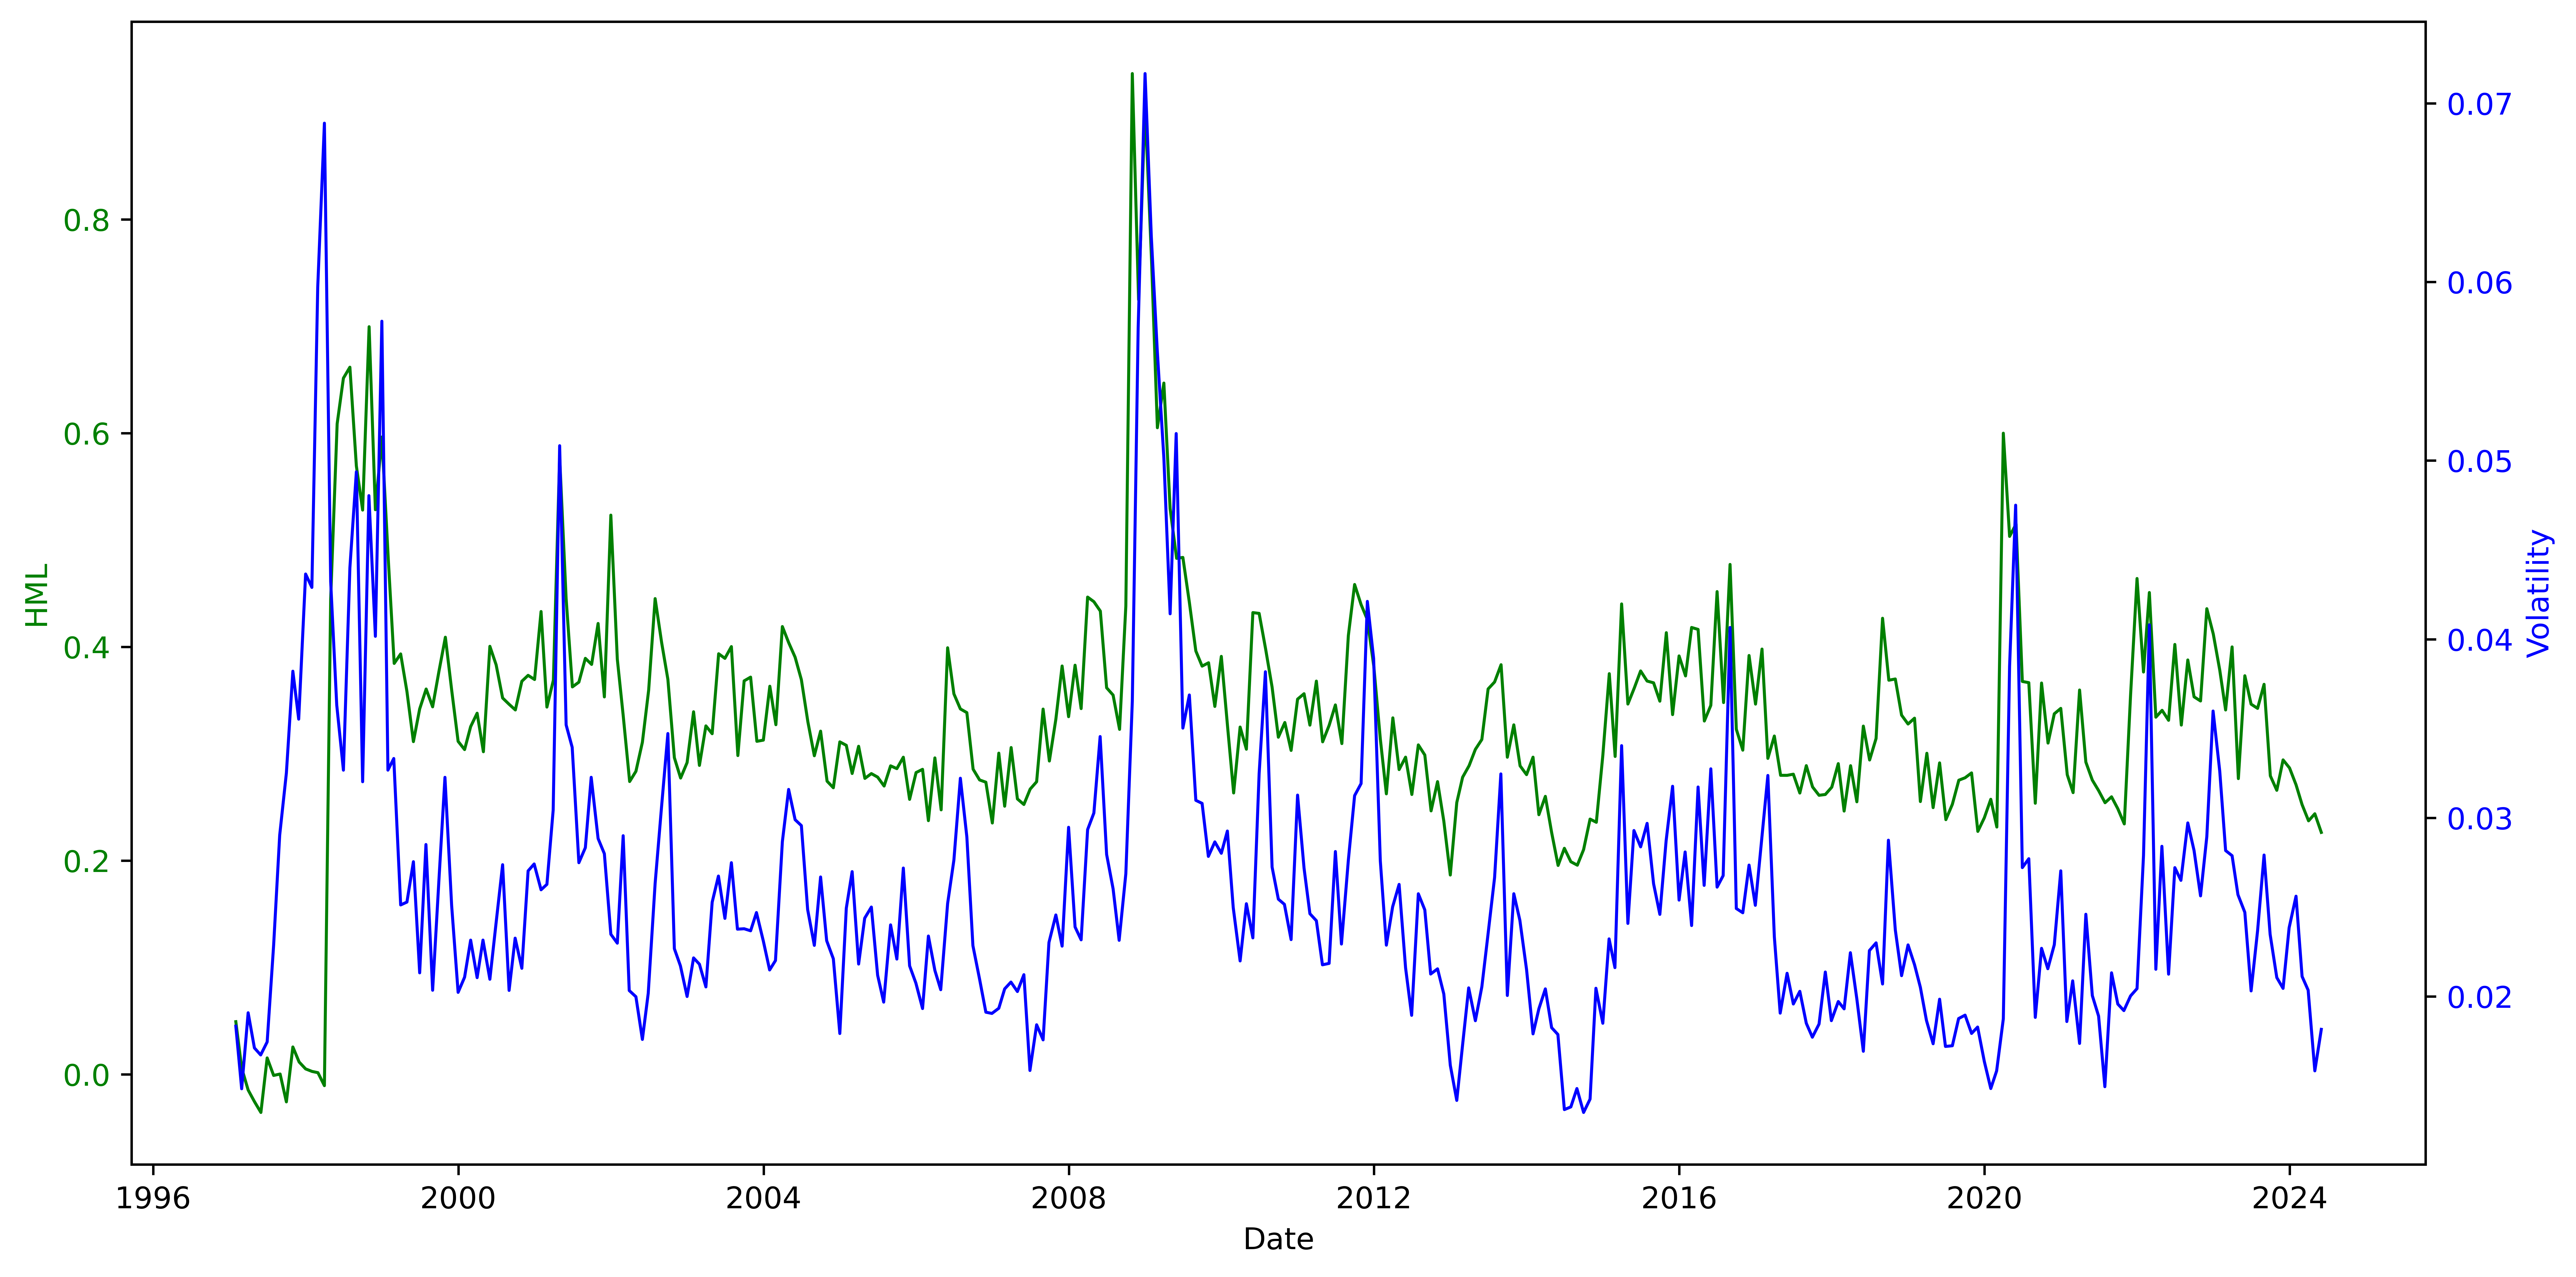

In [45]:
# HML return vs. Volatility
fig, ax1 =plt.subplots(figsize=(12, 6), dpi=800)

ax1.set_xlabel('Date')

ax1.set_ylabel('HML', color='green')
ax1.plot(HML_RET, color='green', label='HML Returns', linewidth=1,)
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()

ax2.set_ylabel('Volatility', color='blue') 
ax2.plot(REL_VOL, color='blue', label='Realised Volatility', linewidth=1, )
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout() 

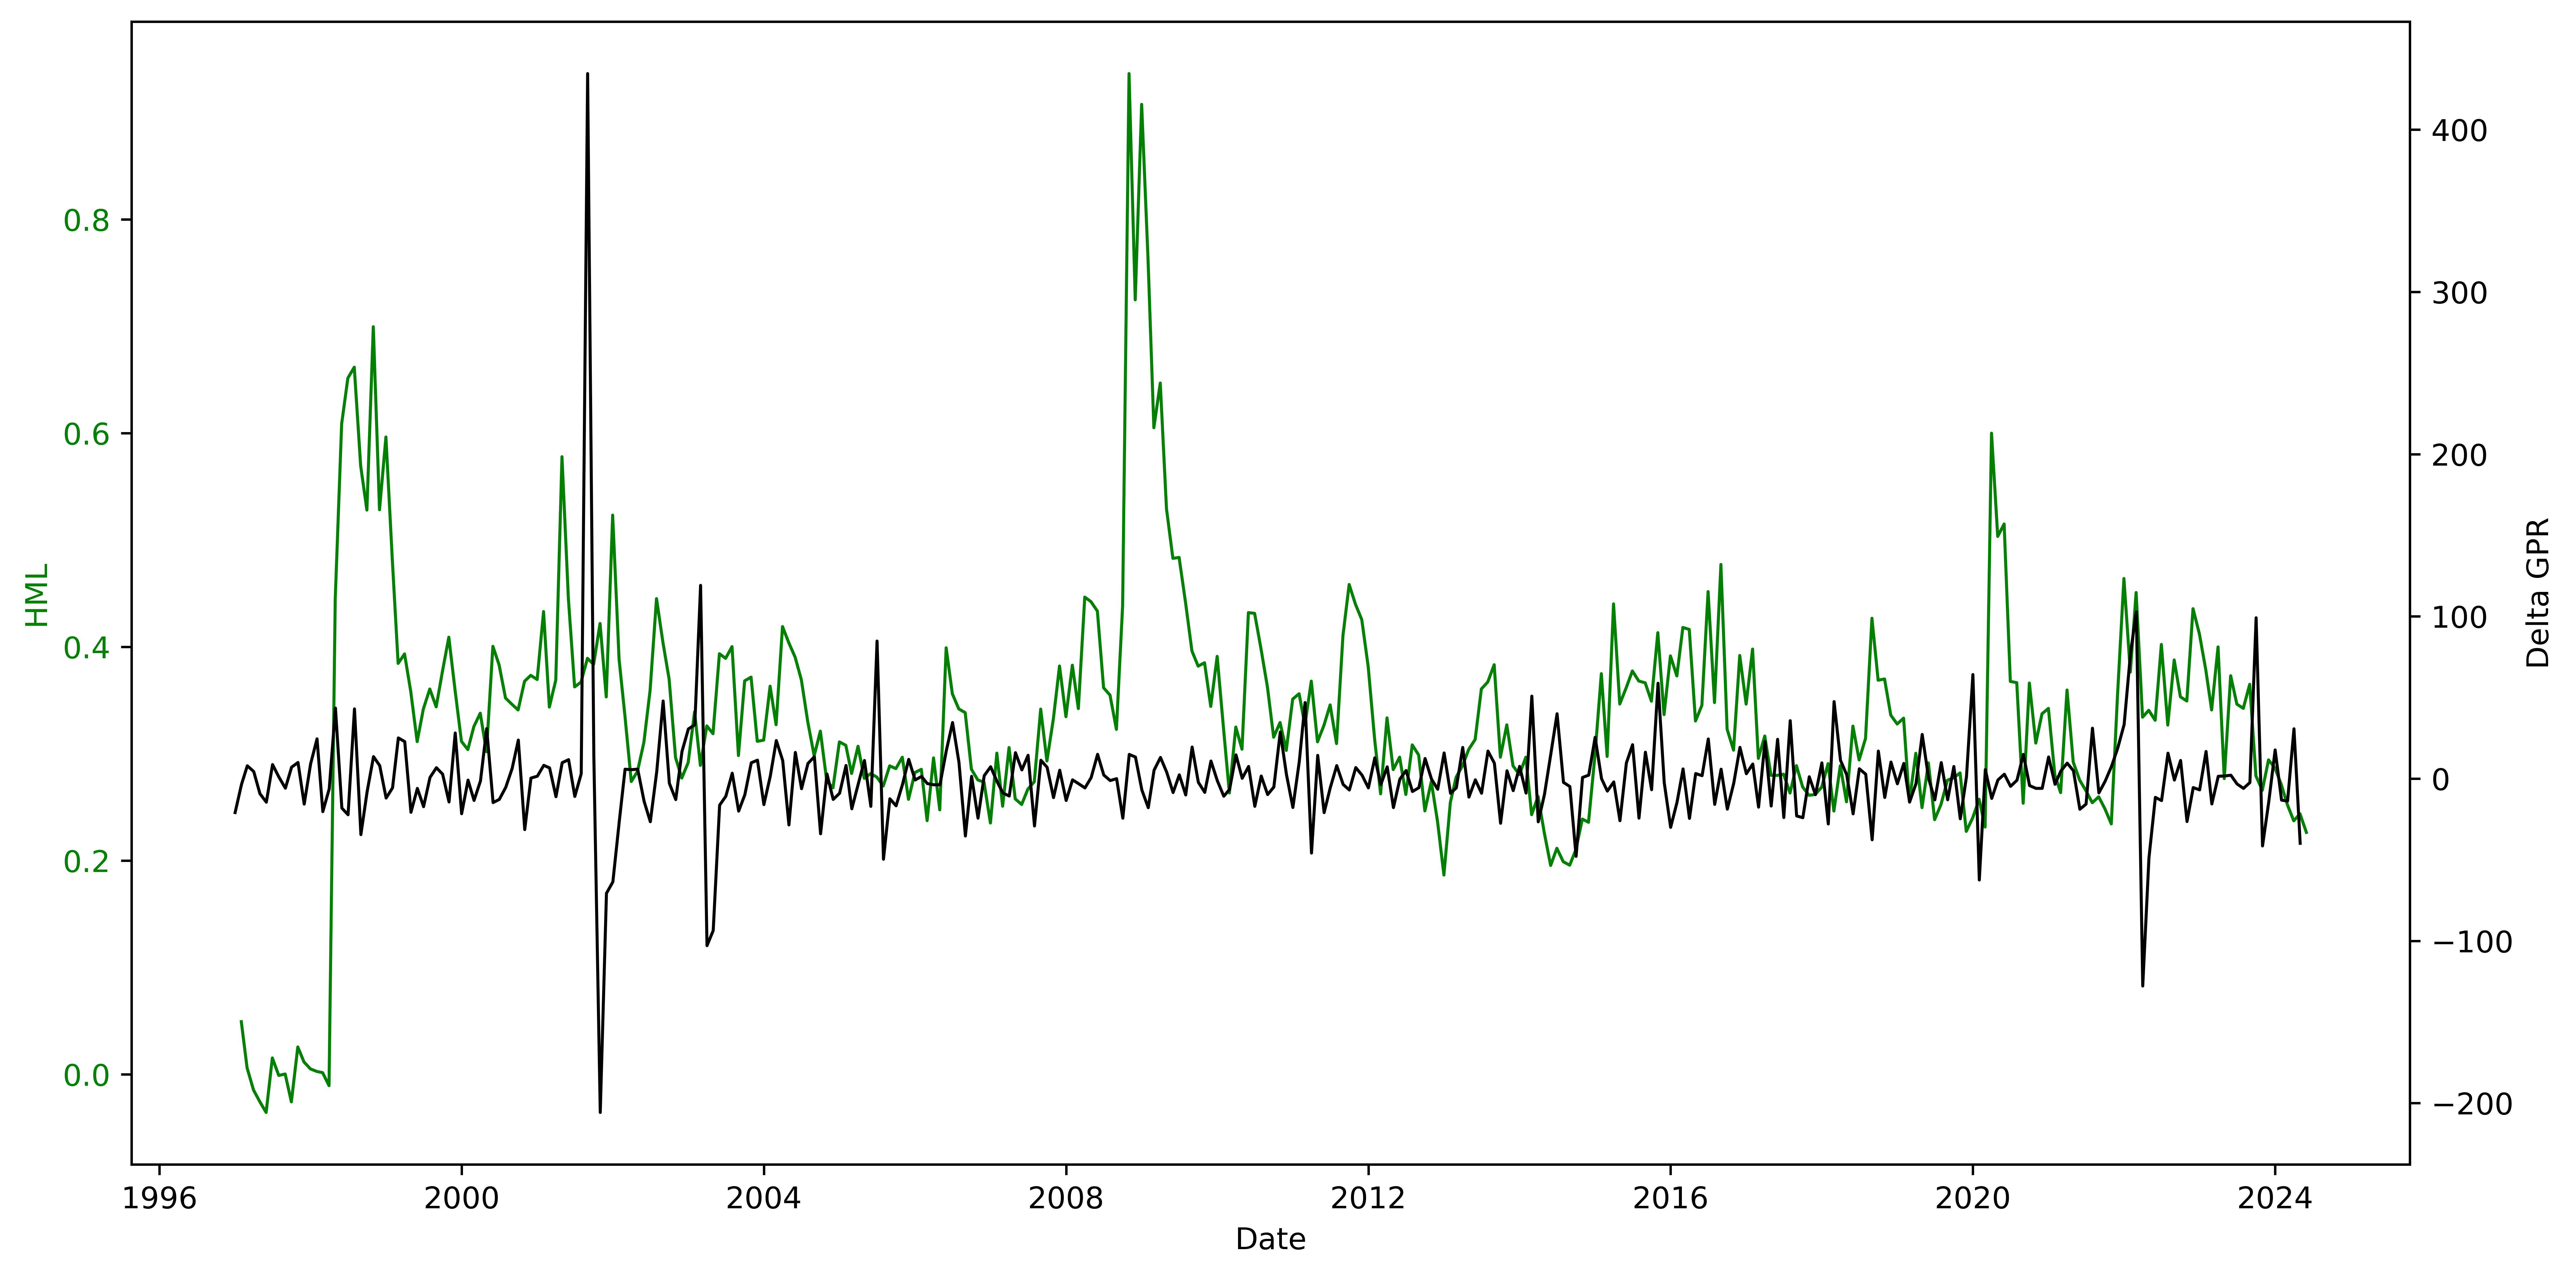

In [46]:
# HML return vs. Delta GPR
fig, ax1 =plt.subplots(figsize=(12, 6), dpi=800)

ax1.set_xlabel('Date')

ax1.set_ylabel('HML', color='green')
ax1.plot(HML_RET, color='green', label='HML Returns', linewidth=1,)
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()

ax2.set_ylabel('Delta GPR', color='black') 
ax2.plot(GPR_Monthly_Diff['GPR'], color='black', label='Delta GPR', linewidth=1, )
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout() 
#plt.title('HML Returns vs. Delta GPR')
#plt.grid()

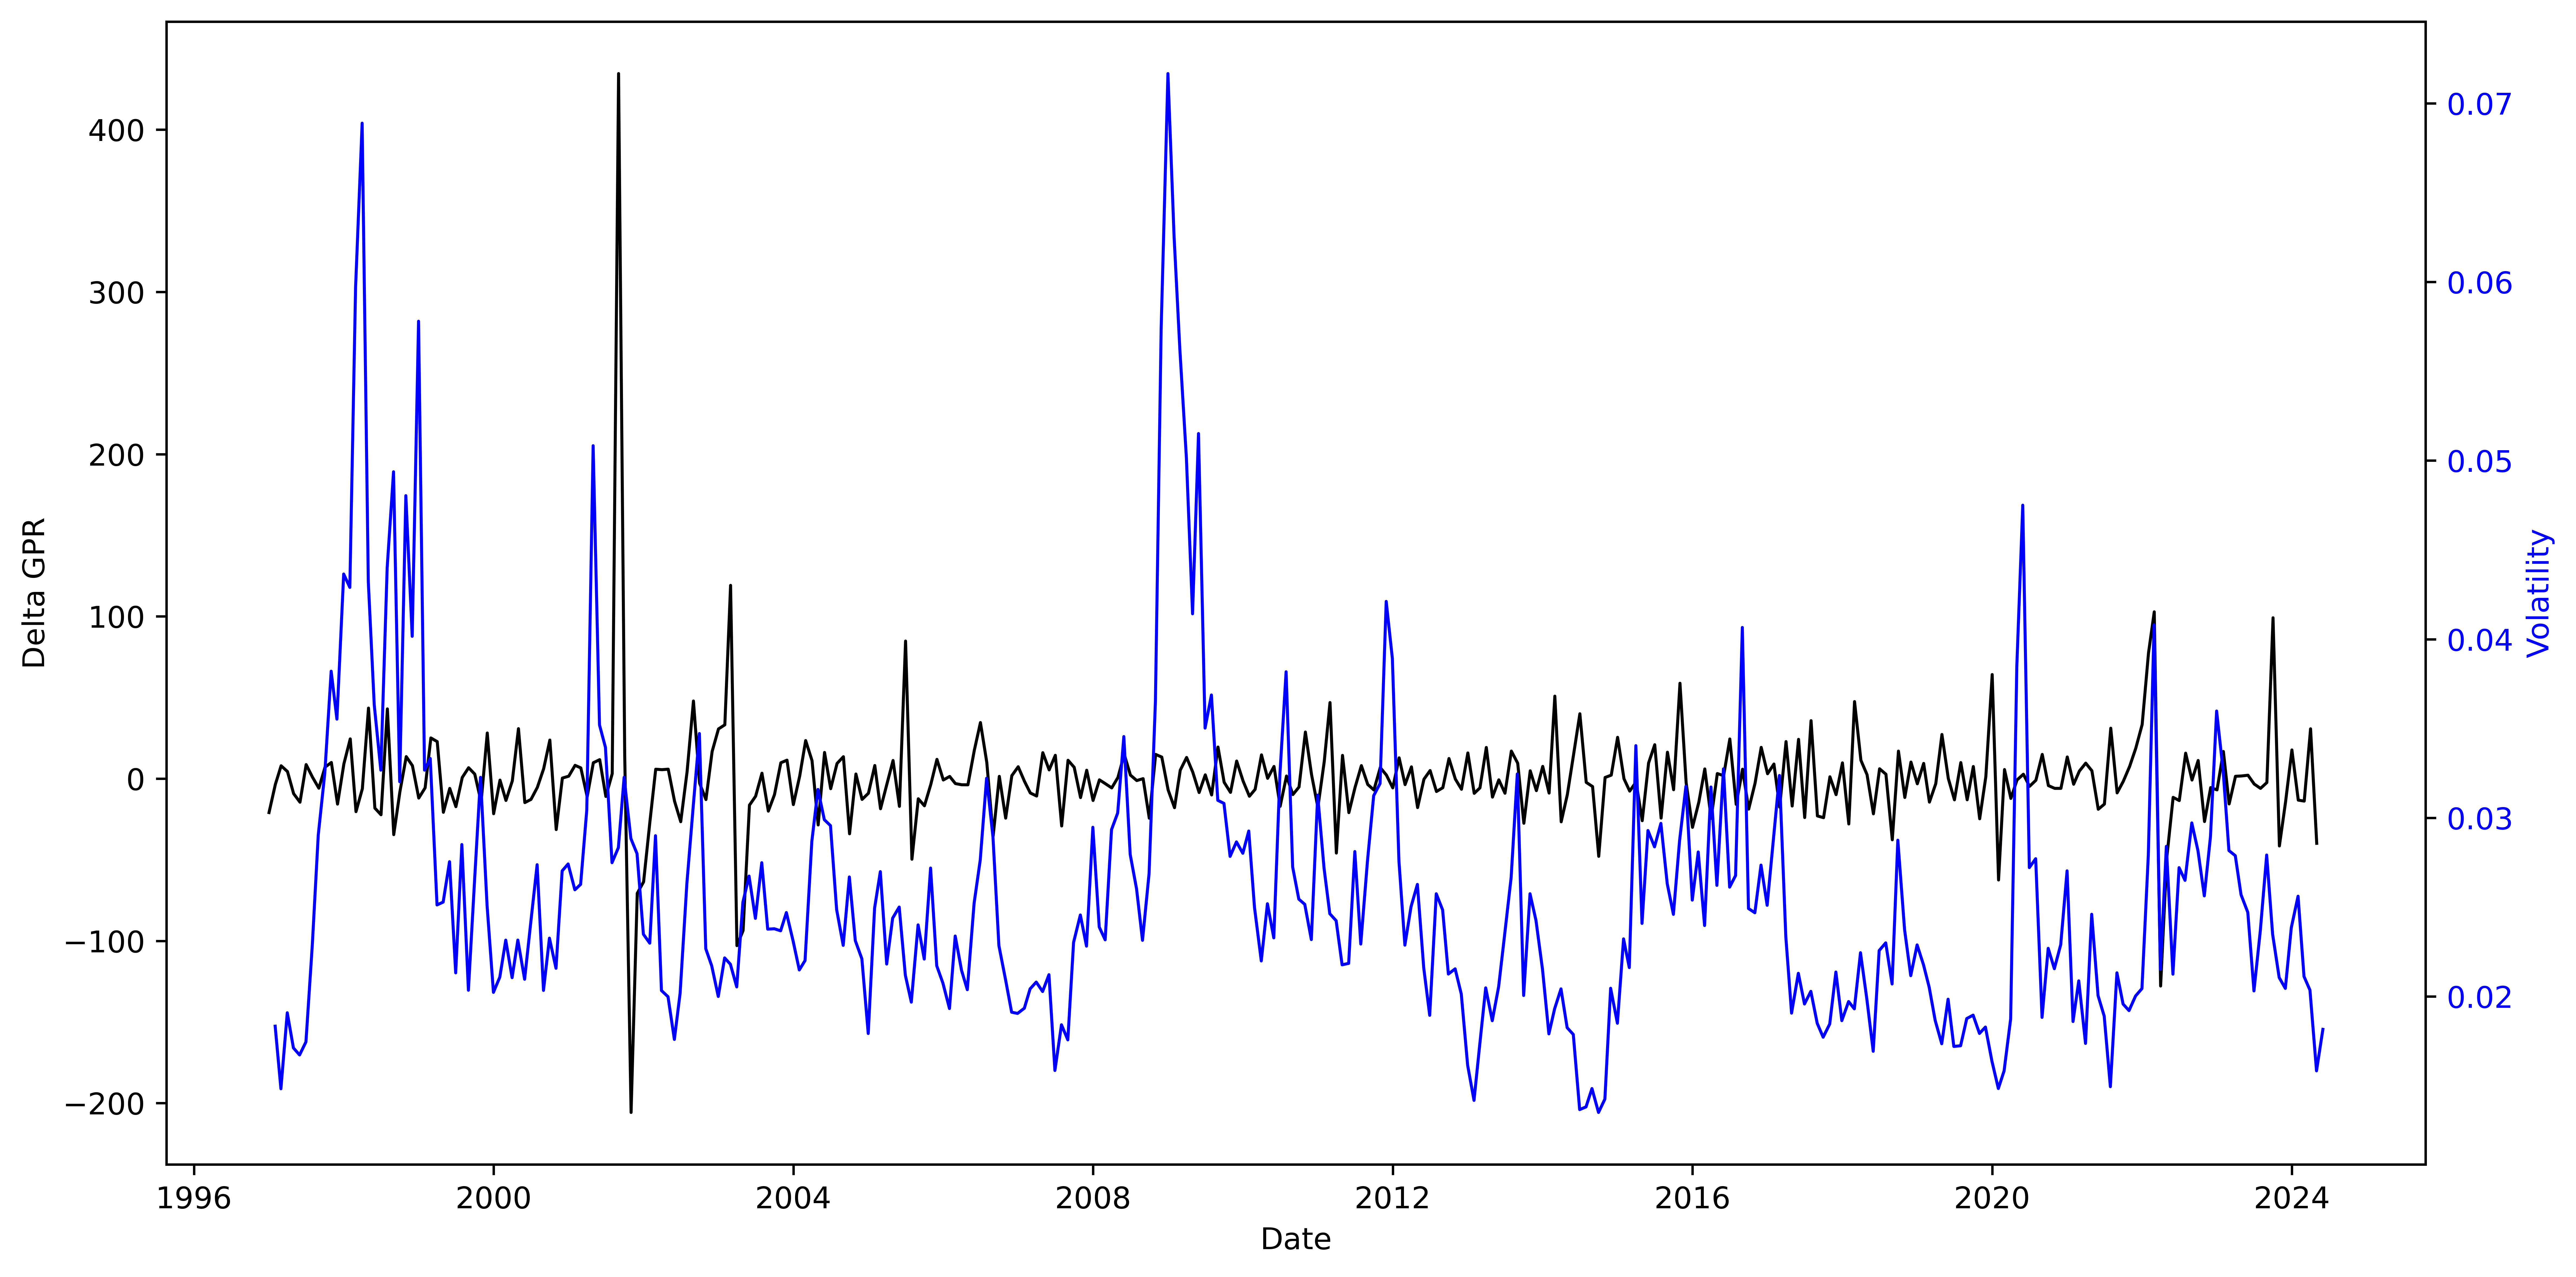

In [47]:
# Delta GPR vs. Volatility
fig, ax1 =plt.subplots(figsize=(12, 6), dpi=800)

ax1.set_xlabel('Date')

ax1.set_ylabel('Delta GPR', color='Black')
ax1.plot(GPR_Monthly_Diff['GPR'], color='Black', label='Delta GPR', linewidth=1)
ax1.tick_params(axis='y', labelcolor='Black')

ax2 = ax1.twinx()

ax2.set_ylabel('Volatility', color='blue') 
ax2.plot(REL_VOL, color='blue', label=' Volatility', linewidth=1, )
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout() 
#plt.title('Delta GPR vs. Realised Volatility')
#plt.grid()